 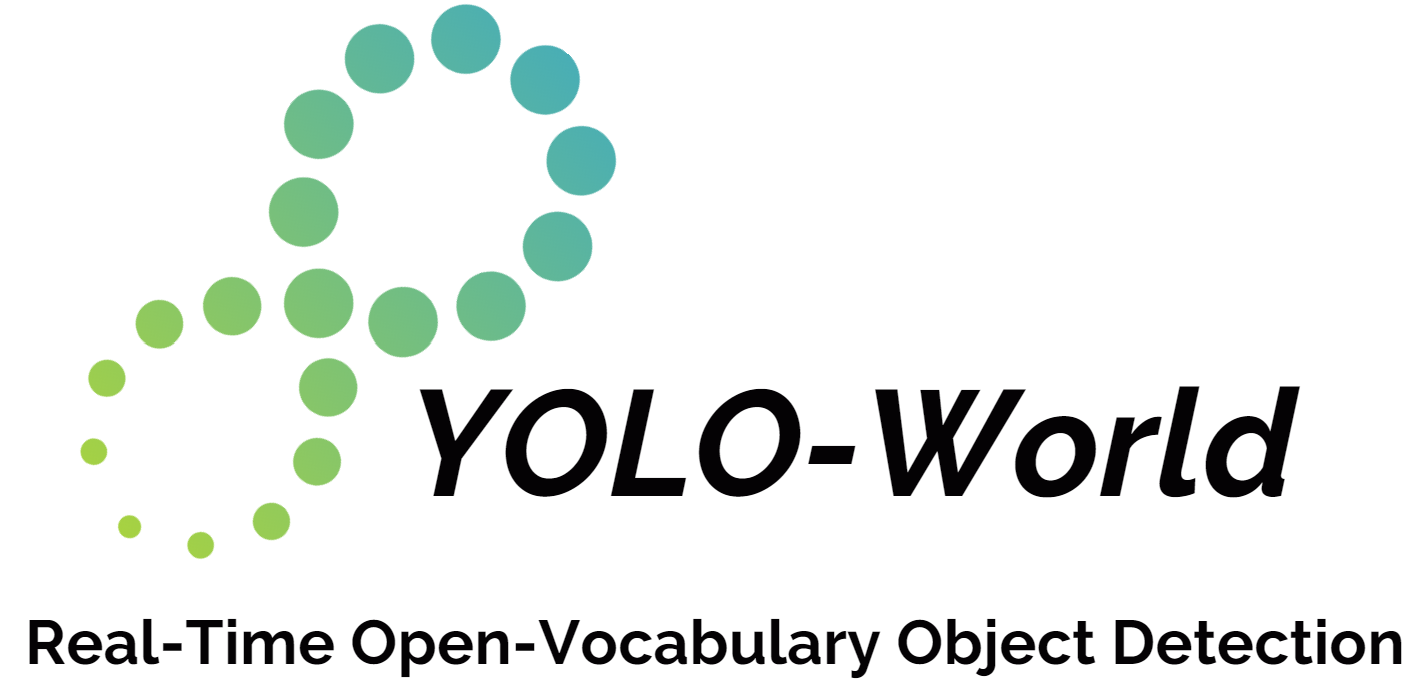


 This YOLO-World notebook is a Inferencing notebook presenting Real-Time Open-Vocabulary Object Detection.

We hope that the resources in this notebook will help you for inferencing.

## Setup

Clone GitHub [repository](https://github.com/AILab-CVC/YOLO-World) and install dependencies

In [6]:
!git clone --recursive https://github.com/AILab-CVC/YOLO-World
%cd YOLO-World/

^C
f:\doctor\YOLO-World\YOLO-World


Submodule path 'third_party/mmyolo': checked out '4d97b3a06609dba94b8ec584be2f2029cfdb7519'


Cloning into 'YOLO-World'...
Submodule 'third_party/mmyolo' (https://github.com/onuralpszr/mmyolo.git) registered for path 'third_party/mmyolo'
Cloning into 'F:/doctor/YOLO-World/YOLO-World/third_party/mmyolo'...


In [2]:
import os
# Install certain version of requests, tqdm, rich for openxlab (fix for yolo_world)
# Install mmcv before avoding compiling of mmcv and shortining waiting time installs "whl" file

if 'COLAB_GPU' in os.environ:
  !pip install requests==2.28.2 tqdm==4.65.0 rich==13.4.2 -q
  %pip install -U openmim -q
  !mim install "mmengine>=0.7.0" -q
  !mim install "mmcv" -q
else:
  !pip install torch wheel requests==2.28.2 tqdm==4.65.0 rich==13.4.2 -q

!pip install -e . -vv -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 16.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.28.2 which is incompatible.
yfinance 0.2.36 requires requests>=2.31, but you have requests 2.28.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 32.5 

In [7]:
# Restart colab session (required for mmengine)
quit()

: 

## Pretrained Models

Download Pretrained weights from Huggingface and set configuration

In [2]:
import os

#%cd YOLO-World/
%cd F:/doctor/YOLO-World
if not os.path.exists("pretrained_weights"):
    os.makedirs("pretrained_weights")

# Download pretrained weights of YOLO-World-l model
!wget https://huggingface.co/spaces/stevengrove/YOLO-World/resolve/main/yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth?download=true
!mv yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth?download=true pretrained_weights/yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth

# Download config file
!wget https://huggingface.co/spaces/stevengrove/YOLO-World/resolve/main/configs/pretrain/yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py?download=true
!mv yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py?download=true configs/pretrain/yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py
# !cp -r yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py /configs/pretrain/

!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

KeyboardInterrupt: 

## Loading model configurations

In [14]:
import numpy as np
import torch
from mmengine.config import Config
from mmengine.dataset import Compose
from mmengine.runner import Runner
from mmengine.runner.amp import autocast
from mmyolo.registry import RUNNERS
from torchvision.ops import nms


if __name__ == "__main__":
    # load config
    cfg = Config.fromfile(
        "F:\doctor\YOLO-World\configs\pretrain\yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py"
    )  #原来的
    #cfg = Config.fromfile("F:\doctor\YOLO-World\configs\pretrain\yolo_world_s_dual_vlpan_l2norm_2e-3_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py")
    cfg.work_dir = "."
    cfg.load_from = "F:\doctor\YOLO-World\pretrained_weights/yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth"  #原来的
    #cfg.load_from = "F:\doctor\YOLO-World\checkpoint\yolo_world_s_clip_base_dual_vlpan_2e-3adamw_32xb16_100e_o365_goldg_train_pretrained-18bea4d2.pth"
    runner = Runner.from_cfg(cfg)
    runner.call_hook("before_run")
    runner.load_or_resume()
    pipeline = cfg.test_dataloader.dataset.pipeline
    runner.pipeline = Compose(pipeline)

    # run model evaluation
    runner.model.eval()

config.py line 457 F:\doctor\YOLO-World\configs\pretrain\yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py
03/07 14:12:42 - mmengine - WARNING - Failed to search registry with scope "mmyolo" in the "log_processor" registry tree. As a workaround, the current "log_processor" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmyolo" is a correct scope, or whether the registry is initialized.
03/07 14:12:42 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 955074342
    GPU 0: NVIDIA GeForce RTX 4060 Ti
    CUDA_HOME: C:\CUDA_wyn\CUDA11.8\CUDA1
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    MSVC: n/a, reason: fileno
    PyTorch: 2.2.1+cu118
 

d:\ProgramData\anaconda3\envs\YOLO_World\lib\site-packages\mmengine\utils\manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


03/07 14:12:47 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
03/07 14:12:47 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(49          ) EMAHook                            
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
after_load_checkpoint:
(49          ) EMAHook                            
 -------------------- 
before_train:
(9           ) YOLOv5ParamSchedulerHook           
(VERY_HIGH   ) RuntimeInfoHook                    
(49          ) EMAHook                            
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHo

In [15]:
def colorstr(*input):
    """
        Helper function for style logging
    """
    *args, string = input if len(input) > 1 else ("bold", input[0])
    colors = {"bold": "\033[1m"}

    return "".join(colors[x] for x in args) + f"{string}"

# Run Image Inference

In [16]:
import PIL.Image
import cv2
import logging
import supervision as sv

bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)

'''class_names = ("person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, "
               "traffic light, fire hydrant, stop sign, parking meter, bench, bird, "
               "cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, "
               "backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, "
               "sports ball, kite, baseball bat, baseball glove, skateboard, "
               "surfboard, tennis racket, bottle, wine glass, cup, fork, knife, "
               "spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, "
               "hot dog, pizza, donut, cake, chair, couch, potted plant, bed, "
               "dining table, toilet, tv, laptop, mouse, remote, keyboard, "
               "cell phone, microwave, oven, toaster, sink, refrigerator, book, "
               "clock, vase, scissors, teddy bear, hair drier, toothbrush")'''

#class_names2 = ("dog, eye, tongue, ear, leash")

class_names = ("strawberry, stem, flowers, leaf, others")


def run_image(
        runner,
        input_image,
        max_num_boxes=100,
        score_thr=0.05,
        nms_thr=0.5,
        output_image="output.png",
):
    #output_image = "runs/detect/"+output_image
    output_image = "F:\doctor\YOLO-World\output_wyn\image_demo/20240307/"+output_image  
    texts = [[t.strip()] for t in class_names.split(",")] + [[" "]]
    data_info = runner.pipeline(dict(img_id=0, img_path=input_image,
                                     texts=texts))

    data_batch = dict(
        inputs=data_info["inputs"].unsqueeze(0),
        data_samples=[data_info["data_samples"]],
    )

    with autocast(enabled=False), torch.no_grad():
        output = runner.model.test_step(data_batch)[0]
        runner.model.class_names = texts
        pred_instances = output.pred_instances

    # nms
    keep_idxs = nms(pred_instances.bboxes, pred_instances.scores, iou_threshold=nms_thr)
    pred_instances = pred_instances[keep_idxs]
    pred_instances = pred_instances[pred_instances.scores.float() > score_thr]

    if len(pred_instances.scores) > max_num_boxes:
        indices = pred_instances.scores.float().topk(max_num_boxes)[1]
        pred_instances = pred_instances[indices]
    output.pred_instances = pred_instances

    # predictions
    pred_instances = pred_instances.cpu().numpy()

    detections = sv.Detections(
        xyxy=pred_instances['bboxes'],
        class_id=pred_instances['labels'],
        confidence=pred_instances['scores']
    )

    # label ids with confidence scores
    labels = [
        f"{class_id} {confidence:0.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    # draw bounding box with label
    image = PIL.Image.open(input_image)
    svimage = np.array(image)
    svimage = bounding_box_annotator.annotate(svimage, detections)
    svimage = label_annotator.annotate(svimage, detections, labels)

    # save output image
    cv2.imwrite(output_image, svimage[:, :, ::-1])
    print(f"Results saved to {colorstr('bold', output_image)}")

    return svimage[:, :, ::-1]


Results saved to F:\doctor\YOLO-World\output_wyn\image_demo/20240307/output.png


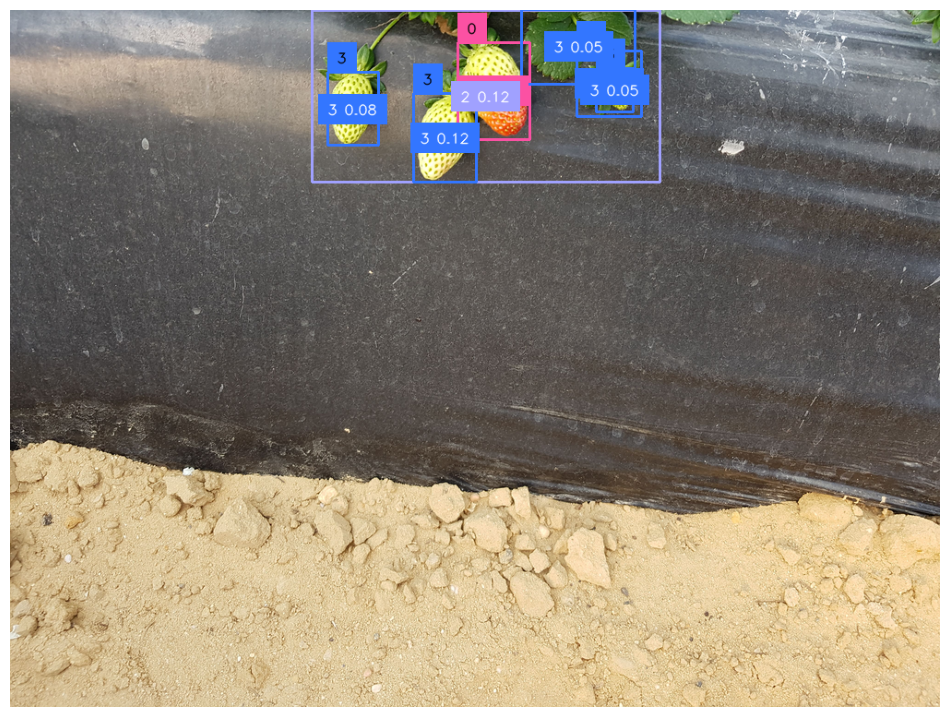

In [17]:
img = run_image(runner,"F:\doctor\YOLO-World\data_wyn\im/1.png")
sv.plot_image(img)